In [1]:
#Импорт библиотек
import random
import math
import datetime
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pandas as pd
import numpy as np

In [2]:
shuffleOn = False

In [3]:
#Создадим класс для данных (признаки и категории)
class Data:
    def __init__(self, signs, category):
        self.signs = signs
        self.category = category

In [4]:
#Функция для копирования данных
def copyData(data):
    return Data(np.copy(data.signs), data.category)

In [5]:
#Функция для заполнения списка данными
def copyDates(dates):
    newList = list()
    for el in dates:
        newList.append(copyData(el))
    return newList

In [6]:
#Функция для вывода данных
def printData(dates):
    for el in dates:
        print(el.signs, '\tclass = ' + el.category.__str__())

In [7]:
#Функция умножения векторов
def multiplyVectors(v1, v2):
    x_len = len(v1)
    res = 0
    for i in range(x_len):
        res += (v1[i] * v2[i])
    return res

In [8]:
#Функция линейного ядра
def linearKernel(v1, v2, c):
    return multiplyVectors(v1, v2) + c

In [9]:
#Функция полиномиального ядра со степенью
def polynomialKernel(v1, v2, c, alpha, d):
    return (multiplyVectors(v1, v2) * alpha + c) ** d

In [10]:
#Функция гауссова ядра с радиальной базисной функцией
def gaussianKernel(x_i, x_j, sigma):
    x_len = len(x_i)
    t = 0
    for i in range(x_len):
        t += (x_i[i] - x_j[i]) ** 2
    return math.exp(-t / (2. * (sigma ** 2)))

In [11]:
#Функция предсказания
def predict(i, coefs, b, dates):
    res = 0.0
    for j in range(len(dates)):
        res += dates[i].signs[j] * dates[j].category * coefs[j]
    res += b
    return res

In [12]:
#Функция предсказания, используя линейное ядро
def modernPredictForLinear(checkedDate, coefs, b, dates, c):
    res = b
    for i in range(len(dates)):
        res += (dates[i].category * coefs[i] * linearKernel(checkedDate.signs, dates[i].signs, c))
    return 1 if res > 0 else -1

In [13]:
#Функция предсказания, используя полиномиальное ядро со степенью
def modernPredictForPolynomial(checkedDate, coefs, b, dates, c, alpha, d):
    res = 0.0
    for i in range(len(dates)):
        res += dates[i].category * coefs[i] * polynomialKernel(checkedDate.signs, dates[i].signs, c, alpha, d)
    res += b
    return 1 if res > 0 else -1

In [14]:
#Функция предсказания, ипользуя гауссово ядро с радиальной базисной функцией
def modernPredictForGaussian(checkedDate, coefs, b, dates, sigma):
    res = 0.0
    for i in range(len(dates)):
        res += dates[i].category * coefs[i] * gaussianKernel(checkedDate.signs, dates[i].signs, sigma)
    res += b
    return 1 if res > 0 else -1

In [15]:
#Реализация метода опорных векторов
def svm(dates, c, amountIter=1000):
    eps = 1e-6
    orderArr = []
    resultAlpha = [0.0 for _ in range(len(dates[0].signs))]
    resultB = 0
    for i in range(len(dates)):
        orderArr.append(i)

    counter = 0
    while counter < amountIter:
        random.shuffle(orderArr)
        for i in range(len(orderArr)):
            e_i = predict(i, resultAlpha, resultB, dates) - dates[i].category
            if (dates[i].category * e_i < -eps and resultAlpha[i] < c) or (dates[i].category * e_i > eps and resultAlpha[i] > 0):
                if i == orderArr[i]:
                    continue
                j = orderArr[i]
                e_j = predict(j, resultAlpha, resultB, dates) - dates[j].category
                a_i_old = resultAlpha[i]
                a_j_old = resultAlpha[j]
                if dates[i].category != dates[j].category:
                    L = max(0.0, resultAlpha[j] - resultAlpha[i])
                    H = min(float(c), float(c) + resultAlpha[j] - resultAlpha[i])
                else:
                    L = max(0.0, resultAlpha[i] + resultAlpha[j] - float(c))
                    H = min(float(c), resultAlpha[i] + resultAlpha[j])
                if abs(L - H) < eps:
                    continue
                nu = 2 * dates[i].signs[j] - dates[i].signs[i] - dates[j].signs[j]
                if nu >= 0:
                    continue

                a_j = resultAlpha[j] - (dates[j].category * (e_i - e_j)) / nu
                if a_j > H:
                    a_j = H
                elif a_j < L:
                    a_j = L
                if abs(a_j - a_j_old) < eps:
                    continue
                resultAlpha[i] = resultAlpha[i] + dates[i].category * dates[j].category * (a_j_old - a_j)
                b1 = resultB - e_i - dates[i].category * (resultAlpha[i] - a_i_old) * dates[i].signs[i] - dates[j].category * (a_j - a_j_old) * dates[i].signs[j]
                b2 = resultB - e_j - dates[i].category * (resultAlpha[i] - a_i_old) * dates[i].signs[j] - dates[j].category * (a_j - a_j_old) * dates[j].signs[j]
                if 0 < resultAlpha[i] < c:
                    resultB = b1
                elif 0 < a_j < c:
                    resultB = b2
                else:
                    resultB = (b1 + b2) / 2
                resultAlpha[j] = a_j
        counter += 1
    for i in range(len(resultAlpha)):
        if resultAlpha[i] < 0:
            resultAlpha[i] = 0

    return resultAlpha, resultB

In [16]:
#Функция чтение данных из файла
def readDates(fileName):
    def convertY(status):
        return 1 if status == 'P' else -1

    dataset = pd.read_csv(fileName)
    if shuffleOn:
        dataset = shuffle(dataset)
    dates = []
    xCord = []
    yCord = []
    for el in dataset.values:
        xCord.append(float(el[0]))
        yCord.append(float(el[1]))
        dates.append(Data(el[:-1], convertY(el[-1])))
    return dates, xCord, yCord

In [17]:
#Функция выделения тестовых данных
def creteTestCase(dates, n, kStep=1):
    newFirstList = list()
    newLastList = list()
    newTarget = list()

    startPos = n * kStep
    endPos = min((n + 1) * kStep, len(dates))

    for el in dates[:startPos]:
        newFirstList.append(copyData(el))
    for el in dates[startPos:endPos]:
        newTarget.append(copyData(el))
    for el in dates[endPos:]:
        newLastList.append(copyData(el))

    return (newFirstList + newLastList, newTarget)

In [18]:
#Данные, возвращает набор данных с линейным ядром
def transformWithLinear(dates, c):
    tmpArr = [[0.0 for _ in range(len(dates))] for _ in range(len(dates))]
    for i in range(len(dates)):
        for j in range(len(dates)):
            tmpArr[i][j] = linearKernel(dates[i].signs, dates[j].signs, c)
    newDates = []
    for i in range(len(tmpArr)):
        newDates.append(Data(tmpArr[i], dates[i].category))
    return newDates

In [19]:
#Данные, возвращает набор данных с полиномиальным ядром
def transformWithPolynomial(dates, c, alpha, d):
    tmpArr = [[0.0 for _ in range(len(dates))] for _ in range(len(dates))]
    for i in range(len(dates)):
        for j in range(len(dates)):
            tmpArr[i][j] = polynomialKernel(dates[i].signs, dates[j].signs, c, alpha, d)
    newDates = []
    for i in range(len(tmpArr)):
        newDates.append(Data(tmpArr[i], dates[i].category))
    return newDates

In [20]:
#Данные, возвращает набор данных с гауссовым ядром
def transformWithGaussian(dates, sigma):
    tmpArr = [[0.0 for _ in range(len(dates))] for _ in range(len(dates))]
    for i in range(len(dates)):
        for j in range(len(dates)):
            tmpArr[i][j] = gaussianKernel(dates[i].signs, dates[j].signs, sigma)
    newDates = []
    for i in range(len(tmpArr)):
        newDates.append(Data(tmpArr[i], dates[i].category))
    return newDates

In [21]:
#Функция поиска наилучших гиперпараметров для линейного ядра
def findBestParametersForLinear(dates, stepSize=20):
    step = stepSize
    #Ограничение на коэф. С
    cSWMArr = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]

    amountSteps = len(cLinArr) * len(cSWMArr)
    progressBar = 0
    bestRes = {"cLin": -1, "cSVM": -1}
    bestAccuracy = 0
    for cLin in cLinArr:
        for cSVM in cSWMArr:
            print('\nПроцент выполнения для линейного ядра: ' + '{:.2%}'.format(progressBar / amountSteps).__str__(), flush=True)
            print(datetime.datetime.now(), flush=True)
            print('dates: cLIN', cLin, 'cSVM', cSVM, flush=True)
            nice = 0
            for i in range(len(dates)):
                if i * step > len(dates):
                    break
                print('i=' + i.__str__(), 'step=' + (i * step).__str__(), flush=True)
                trainDates, checkDates = creteTestCase(dates, i, kStep=step)
                trainDates2 = transformWithLinear(trainDates, cLin)
                alphas, b = svm(trainDates2, cSVM)
                for testEl in checkDates:
                    yPredicted = modernPredictForLinear(testEl, alphas, b, trainDates, cLin)
                    if yPredicted == testEl.category:
                        nice += 1

            accuracy = nice / len(dates)
            if bestAccuracy < accuracy:
                bestAccuracy = accuracy
                print("Найдена лучшая точность (accuracy)", accuracy, flush=True)
                bestRes = {"cLin": cLin, "cSVM": cSVM}
            else:
                print("Никаких изменений, найденная на данном этапе точность = ", accuracy, ", лучшая = ", bestAccuracy, flush=True)
            progressBar += 1
    print('\nНаилучший результат: cLin=' + bestRes["cLin"].__str__() + ' cSVM=' + bestRes["cSVM"].__str__(), flush=True)
    return bestRes

In [22]:
#Функция поиска наилучших гиперпараметров для полиномиального ядра
def findBestParametersForPolynomial(dates, stepSize=20):
    step = stepSize
    #Степени полинома (от 2 до 5)
    dPolArr = [2, 3, 4, 5]
    #Коэффициент опорных векторов C
    cSWMArr = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]

    amountSteps = len(cPolArr) * len(alphaPolArr) * len(dPolArr) * len(cSWMArr)
    progressBar = 0
    bestRes = {"cPol": -1, "alphaPol": -1, "dPol": -1, "cSVM": -1}
    bestAccuracy = 0
    for cPol in cPolArr:
        for alphaPol in alphaPolArr:
            for dPol in dPolArr:
                for cSVM in cSWMArr:
                    print('\nПроцент выполнения для полиномиального ядра: ' + '{:.2%}'.format(progressBar / amountSteps).__str__(), flush=True)
                    print(datetime.datetime.now(), flush=True)
                    print('dates: cPol', cPol, 'alphaPol', alphaPol, 'dPol', dPol, 'cSVM', cSVM, flush=True)
                    nice = 0
                    for i in range(len(dates)):
                        if i * step > len(dates):
                            break
                        print('i=' + i.__str__(), 'step=' + (i * step).__str__(), flush=True)
                        trainDates, checkDates = creteTestCase(dates, i, kStep=step)
                        trainDates2 = transformWithPolynomial(trainDates, cPol, alphaPol, dPol)
                        alphas, b = svm(trainDates2, cSVM)
                        for testEl in checkDates:
                            yPredicted = modernPredictForPolynomial(testEl, alphas, b, trainDates, cPol, alphaPol, dPol)
                            if yPredicted == testEl.category:
                                nice += 1
                    accuracy = nice / len(dates)
                    if bestAccuracy < accuracy:
                        bestAccuracy = accuracy
                        print("Найдена лучшая точность (accuracy)", accuracy, flush=True)
                        bestRes = {"cPol": cPol, "alphaPol": alphaPol, "dPol": dPol, "cSVM": cSVM}
                    else:
                        print("Никаких изменений, найденная на данном этапе точность = ", accuracy, ", лучшая = ", bestAccuracy, flush=True)
                    progressBar += 1
    print('\nНаилучший результат: cPol=' + bestRes["cPol"].__str__() + ' alphaPol=' + bestRes["alphaPol"].__str__() + ' dPol=' + bestRes["dPol"].__str__() + ' cSVM=' + bestRes["cSVM"].__str__(), flush=True)
    return bestRes

In [23]:
#Функция поиска лучших гиперпараметров для гауссова ядра
def findBestParametersForGaussian(dates, stepSize=20):
    step = stepSize

    Beta = [1,2,3,4,5]
    cSWMArr = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]

    amountSteps = len(sigmaGauArr) * len(cSWMArr)
    progressBar = 0
    bestRes = {"sigmaGau": -1, "cSVM": -1}
    bestAccuracy = 0
    for sigmaGau in sigmaGauArr:
        for cSVM in cSWMArr:
            print('\nПроцент выполнения для гауссова ядра: ' + '{:.2%}'.format(progressBar / amountSteps).__str__(), flush=True)
            print(datetime.datetime.now(), flush=True)
            print('dates: sigmaGau', sigmaGau, 'cSVM', cSVM, flush=True)
            nice = 0
            for i in range(len(dates)):
                if i * step > len(dates):
                    break
                print('i=' + i.__str__(), 'step=' + (i * step).__str__(), flush=True)
                trainDates, checkDates = creteTestCase(dates, i, kStep=step)
                trainDates2 = transformWithGaussian(trainDates, sigmaGau)
                alphas, b = svm(trainDates2, cSVM)
                for testEl in checkDates:
                    yPredicted = modernPredictForGaussian(testEl, alphas, b, trainDates, sigmaGau)
                    if yPredicted == testEl.category:
                        nice += 1
            accuracy = nice / len(dates)
            if bestAccuracy < accuracy:
                bestAccuracy = accuracy
                print("Найдена лучшая точность (accuracy)", accuracy, flush=True)
                bestRes = {"sigmaGau": sigmaGau, "cSVM": cSVM}
            else:
                print("Никаких изменений, найденная на данном этапе точность = ", accuracy, ", лучшая = ", bestAccuracy, flush=True)
            progressBar += 1
    print('\nНаилучший результат: sigmaGau=' + bestRes["sigmaGau"].__str__() + ' cSVM=' + bestRes["cSVM"].__str__(), flush=True)
    return bestRes

In [24]:
#Функция прогноза при применении линейного ядра
def superPredictForLinear(field, dates, cLin, cSVM):
    trainDates = transformWithLinear(dates, cLin)
    alphas, b = svm(trainDates, cSVM)
    globalArr = []
    progressBar = 0
    for el in field:
        #print('Progress ' + '{:.2%}'.format(progressBar / len(field)).__str__())
        predictY = modernPredictForLinear(Data(el, 1), alphas, b, dates, cLin)
        globalArr.append(predictY)
        progressBar += 1
    return globalArr

In [25]:
#Функция прогноза при применении полиномиального ядра
def superPredictForPolynomial(field, dates, cPol, alphaPol, dPol, cSVM):
    trainDates = transformWithPolynomial(dates, cPol, alphaPol, dPol)
    alphas, b = svm(trainDates, cSVM)
    globalArr = []
    progressBar = 0
    for el in field:
        #print('Progress ' + '{:.2%}'.format(progressBar / len(field)).__str__())
        predictY = modernPredictForPolynomial(Data(el, 1), alphas, b, dates, cPol, alphaPol, dPol)
        globalArr.append(predictY)
        progressBar += 1
    return globalArr

In [26]:
#Функция прогноза при применении гауссова ядра
def superPredictForGaussian(field, dates, sigmaGau, cSVM):
    trainDates = transformWithGaussian(dates, sigmaGau)
    alphas, b = svm(trainDates, cSVM)
    globalArr = []
    progressBar = 0
    for el in field:
        #print('Progress ' + '{:.2%}'.format(progressBar / len(field)).__str__())
        predictY = modernPredictForGaussian(Data(el, 1), alphas, b, dates, sigmaGau)
        globalArr.append(predictY)
        progressBar += 1
    return globalArr

In [27]:
#Построение графика при применении линейного ядра
def printPlotsLinear(dates, xArr, yArr, cLin, cSVM):
    h = 0.1
    fig, ax = plt.subplots()
    x_min, x_max = min(xArr) - 1, max(xArr) + 1
    y_min, y_max = min(yArr) - 1, max(yArr) + 1
    xxx, yyy = np.meshgrid(np.arange(x_min, x_max, h),
                           np.arange(y_min, y_max, h))

    field = np.c_[xxx.ravel(), yyy.ravel()]

    globalArr = superPredictForLinear(field, dates, cLin, cSVM)
    z = (np.array(globalArr)).reshape(xxx.shape)
    plt.contourf(xxx, yyy, z, alpha=1)

    elMinus = [[], []]
    elPlus = [[], []]
    for el in dates:
        if el.category == 1:
            elPlus[0].append(el.signs[0])
            elPlus[1].append(el.signs[1])
        else:
            elMinus[0].append(el.signs[0])
            elMinus[1].append(el.signs[1])

    plt.scatter(elMinus[0], elMinus[1], c='red')
    plt.scatter(elPlus[0], elPlus[1], c='green')
    ax.set_title('Применение линейного ядра')
    plt.show()

In [28]:
#Построение графика при применении полиномиального ядра
def printPlotsPolynomial(dates, xArr, yArr, cPol, alphaPol, dPol, cSVM):
    h = 0.1
    fig, ax = plt.subplots()
    x_min, x_max = min(xArr) - 1, max(xArr) + 1
    y_min, y_max = min(yArr) - 1, max(yArr) + 1
    xxx, yyy = np.meshgrid(np.arange(x_min, x_max, h),
                           np.arange(y_min, y_max, h))

    field = np.c_[xxx.ravel(), yyy.ravel()]

    globalArr = superPredictForPolynomial(field, dates, cPol, alphaPol, dPol, cSVM)
    z = (np.array(globalArr)).reshape(xxx.shape)
    plt.contourf(xxx, yyy, z, alpha=1)

    elMinus = [[], []]
    elPlus = [[], []]
    for el in dates:
        if el.category == 1:
            elPlus[0].append(el.signs[0])
            elPlus[1].append(el.signs[1])
        else:
            elMinus[0].append(el.signs[0])
            elMinus[1].append(el.signs[1])

    plt.scatter(elMinus[0], elMinus[1], c='red')
    plt.scatter(elPlus[0], elPlus[1], c='green')
    ax.set_title('Применение полиномиального ядра')
    plt.show()

In [29]:
#Построение графика при применении гауссова ядра
def printPlotsGaussian(dates, xArr, yArr, sigmaGau, cSVM):
    h = 0.1
    fig, ax = plt.subplots()
    x_min, x_max = min(xArr) - 1, max(xArr) + 1
    y_min, y_max = min(yArr) - 1, max(yArr) + 1
    xxx, yyy = np.meshgrid(np.arange(x_min, x_max, h),
                           np.arange(y_min, y_max, h))

    field = np.c_[xxx.ravel(), yyy.ravel()]

    globalArr = superPredictForGaussian(field, dates, sigmaGau, cSVM)
    z = (np.array(globalArr)).reshape(xxx.shape)
    plt.contourf(xxx, yyy, z, alpha=1)

    elMinus = [[], []]
    elPlus = [[], []]
    for el in dates:
        if el.category == 1:
            elPlus[0].append(el.signs[0])
            elPlus[1].append(el.signs[1])
        else:
            elMinus[0].append(el.signs[0])
            elMinus[1].append(el.signs[1])

    plt.scatter(elMinus[0], elMinus[1], c='red')
    plt.scatter(elPlus[0], elPlus[1], c='green')
    ax.set_title('Применение гауссова ядра')
    plt.show()

In [30]:
if __name__ == '__main__':
    shuffleOn = False
    dates, xCord, yCord = readDates('chips.csv')
    # dates, xCord, yCord = readDates('geyser.csv')
    printData(dates)

    # print for chips.csv
    # printPlotsLinear(dates, xCord, yCord, 1.5, 100)
    # printPlotsPolynomial(dates, xCord, yCord, 8, 1.0, 3, 7.0)
    # printPlotsGaussian(dates, xCord, yCord, 0.5, 50)

    # print for geyser.csv
    # printPlotsLinear(dates, xCord, yCord, 0, 25)
    # printPlotsPolynomial(dates, xCord, yCord, 0.01, 1, 2, 0.01)
    # printPlotsGaussian(dates, xCord, yCord, 5, 50)

    # linear
    # for chips
    # findBestParametersForLinear(dates)
    # for geyser
    # findBestParametersForLinear(dates, stepSize=50)

    # polynomial
    # for chips
    # findBestParametersForPolynomial(dates)
    # for geyser
    # findBestParametersForPolynomial(dates, stepSize=70)

    # gaussian
    # for chips
    # findBestParametersForGaussian(dates)
    # for geyser
    # findBestParametersForGaussian(dates, stepSize=50)

[0.051267 0.69956] 	class = 1
[-0.092742 0.68494] 	class = 1
[-0.21371 0.69225] 	class = 1
[-0.375 0.50219] 	class = 1
[-0.51325 0.46564] 	class = 1
[-0.52477 0.2098] 	class = 1
[-0.39804 0.034357] 	class = 1
[-0.30588 -0.19225] 	class = 1
[0.016705 -0.40424] 	class = 1
[0.13191 -0.51389] 	class = 1
[0.38537 -0.56506] 	class = 1
[0.52938 -0.5212] 	class = 1
[0.63882 -0.24342] 	class = 1
[0.73675 -0.18494] 	class = 1
[0.54666 0.48757] 	class = 1
[0.322 0.5826] 	class = 1
[0.16647 0.53874] 	class = 1
[-0.046659 0.81652] 	class = 1
[-0.17339 0.69956] 	class = 1
[-0.47869 0.63377] 	class = 1
[-0.60541 0.59722] 	class = 1
[-0.62846 0.33406] 	class = 1
[-0.59389 0.005117] 	class = 1
[-0.42108 -0.27266] 	class = 1
[-0.11578 -0.39693] 	class = 1
[0.20104 -0.60161] 	class = 1
[0.46601 -0.53582] 	class = 1
[0.67339 -0.53582] 	class = 1
[-0.13882 0.54605] 	class = 1
[-0.29435 0.77997] 	class = 1
[-0.26555 0.96272] 	class = 1
[-0.16187 0.8019] 	class = 1
[-0.17339 0.64839] 	class = 1
[-0.28283 0.4

In [31]:
# Поиск лучших гиперпараметров для линеного ядра
# для датасета chips
findBestParametersForLinear(dates)


Процент выполнения для линейного ядра: 0.00%
2022-04-12 12:38:00.925691
dates: cLIN 0 cSVM 0.1
i=0 step=0
i=1 step=20
i=2 step=40
i=3 step=60
i=4 step=80
i=5 step=100
Найдена лучшая точность (accuracy) 0.01694915254237288

Процент выполнения для линейного ядра: 2.04%
2022-04-12 12:38:15.449015
dates: cLIN 0 cSVM 0.5
i=0 step=0
i=1 step=20
i=2 step=40
i=3 step=60
i=4 step=80
i=5 step=100
Найдена лучшая точность (accuracy) 0.0423728813559322

Процент выполнения для линейного ядра: 4.08%
2022-04-12 12:38:29.641003
dates: cLIN 0 cSVM 1.0
i=0 step=0
i=1 step=20
i=2 step=40
i=3 step=60
i=4 step=80
i=5 step=100
Найдена лучшая точность (accuracy) 0.05084745762711865

Процент выполнения для линейного ядра: 6.12%
2022-04-12 12:38:43.651665
dates: cLIN 0 cSVM 10.0
i=0 step=0
i=1 step=20
i=2 step=40
i=3 step=60
i=4 step=80
i=5 step=100
Никаких изменений, найденная на данном этапе точность =  0.05084745762711865 , лучшая =  0.05084745762711865

Процент выполнения для линейного ядра: 8.16%
2022-04-

{'cLin': 0, 'cSVM': 50.0}

In [32]:
# Поиск лучших гиперпараметров для полиномиального ядра
# для датасета chips
findBestParametersForPolynomial(dates)


Процент выполнения для полиномиального ядра: 0.00%
2022-04-12 12:50:10.548963
dates: cPol 0 alphaPol 0.1 dPol 2 cSVM 0.01
i=0 step=0
i=1 step=20
i=2 step=40
i=3 step=60
i=4 step=80
i=5 step=100
Найдена лучшая точность (accuracy) 0.01694915254237288

Процент выполнения для полиномиального ядра: 0.17%
2022-04-12 12:50:24.431424
dates: cPol 0 alphaPol 0.1 dPol 2 cSVM 1.0
i=0 step=0
i=1 step=20
i=2 step=40
i=3 step=60
i=4 step=80
i=5 step=100
Никаких изменений, найденная на данном этапе точность =  0.01694915254237288 , лучшая =  0.01694915254237288

Процент выполнения для полиномиального ядра: 0.33%
2022-04-12 12:50:38.442357
dates: cPol 0 alphaPol 0.1 dPol 2 cSVM 7.0
i=0 step=0
i=1 step=20
i=2 step=40
i=3 step=60
i=4 step=80
i=5 step=100
Никаких изменений, найденная на данном этапе точность =  0.01694915254237288 , лучшая =  0.01694915254237288

Процент выполнения для полиномиального ядра: 0.50%
2022-04-12 12:50:52.494216
dates: cPol 0 alphaPol 0.1 dPol 2 cSVM 25.0
i=0 step=0
i=1 step=2

{'cPol': 30.0, 'alphaPol': 1, 'dPol': 5, 'cSVM': 7.0}

In [33]:
# Поиск лучших гиперпараметров для гауссова ядра
# для датасета chips
findBestParametersForGaussian(dates)


Процент выполнения для гауссова ядра: 0.00%
2022-04-12 16:08:21.111432
dates: sigmaGau 0.01 cSVM 0.01
i=0 step=0
i=1 step=20
i=2 step=40
i=3 step=60
i=4 step=80
i=5 step=100
Найдена лучшая точность (accuracy) 0.01694915254237288

Процент выполнения для гауссова ядра: 2.38%
2022-04-12 16:08:35.479993
dates: sigmaGau 0.01 cSVM 0.3
i=0 step=0
i=1 step=20
i=2 step=40
i=3 step=60
i=4 step=80
i=5 step=100
Никаких изменений, найденная на данном этапе точность =  0.01694915254237288 , лучшая =  0.01694915254237288

Процент выполнения для гауссова ядра: 4.76%
2022-04-12 16:08:49.915406
dates: sigmaGau 0.01 cSVM 1.0
i=0 step=0
i=1 step=20
i=2 step=40
i=3 step=60
i=4 step=80
i=5 step=100
Никаких изменений, найденная на данном этапе точность =  0.01694915254237288 , лучшая =  0.01694915254237288

Процент выполнения для гауссова ядра: 7.14%
2022-04-12 16:09:04.995042
dates: sigmaGau 0.01 cSVM 7.0
i=0 step=0
i=1 step=20
i=2 step=40
i=3 step=60
i=4 step=80
i=5 step=100
Никаких изменений, найденная н

{'sigmaGau': 1, 'cSVM': 25.0}

In [30]:
# Работаем с датасетом geyser.csv
dates, xCord, yCord = readDates('geyser.csv')
printData(dates)

[1 4.4] 	class = -1
[1 3.9] 	class = -1
[1 4.0] 	class = 1
[1 4.0] 	class = -1
[1 3.5] 	class = -1
[1 4.1] 	class = -1
[1 2.3] 	class = 1
[1 4.7] 	class = -1
[1 1.7] 	class = 1
[1 4.9] 	class = -1
[1 1.7] 	class = 1
[1 4.6] 	class = -1
[1 3.4] 	class = -1
[2 4.3] 	class = -1
[2 1.7] 	class = 1
[2 3.9] 	class = -1
[2 3.7] 	class = 1
[2 3.1] 	class = 1
[2 4.0] 	class = -1
[2 1.8] 	class = 1
[2 4.1] 	class = -1
[2 1.8] 	class = 1
[2 3.2] 	class = -1
[2 1.9] 	class = 1
[2 4.6] 	class = -1
[2 2.0] 	class = 1
[3 4.5] 	class = -1
[3 3.9] 	class = -1
[3 4.3] 	class = -1
[3 2.3] 	class = 1
[3 3.8] 	class = -1
[3 1.9] 	class = 1
[3 4.6] 	class = -1
[3 1.8] 	class = 1
[3 4.7] 	class = -1
[3 1.8] 	class = 1
[3 4.6] 	class = -1
[3 1.9] 	class = 1
[3 3.5] 	class = -1
[4 4.0] 	class = -1
[4 3.7] 	class = -1
[4 3.7] 	class = 1
[4 4.3] 	class = 1
[4 3.6] 	class = -1
[4 3.8] 	class = -1
[4 3.8] 	class = -1
[4 3.8] 	class = -1
[4 2.5] 	class = 1
[4 4.5] 	class = -1
[4 4.1] 	class = 1
[4 3.7] 	class = -1


In [31]:
# Поиск лучших гиперпараметров для линейного ядра
# для датасета geyser
findBestParametersForLinear(dates, stepSize=50)


Процент выполнения для линейного ядра: 0.00%
2022-04-12 22:47:35.320503
dates: cLIN 0 cSVM 0.1
i=0 step=0
i=1 step=50
i=2 step=100
i=3 step=150
i=4 step=200
Найдена лучшая точность (accuracy) 0.8963963963963963

Процент выполнения для линейного ядра: 2.04%
2022-04-12 22:48:19.324250
dates: cLIN 0 cSVM 0.5
i=0 step=0
i=1 step=50
i=2 step=100
i=3 step=150
i=4 step=200
Найдена лучшая точность (accuracy) 0.9054054054054054

Процент выполнения для линейного ядра: 4.08%
2022-04-12 22:49:05.398762
dates: cLIN 0 cSVM 1.0
i=0 step=0
i=1 step=50
i=2 step=100
i=3 step=150
i=4 step=200
Никаких изменений, найденная на данном этапе точность =  0.9009009009009009 , лучшая =  0.9054054054054054

Процент выполнения для линейного ядра: 6.12%
2022-04-12 22:49:52.352692
dates: cLIN 0 cSVM 10.0
i=0 step=0
i=1 step=50
i=2 step=100
i=3 step=150
i=4 step=200
Никаких изменений, найденная на данном этапе точность =  0.9054054054054054 , лучшая =  0.9054054054054054

Процент выполнения для линейного ядра: 8.16%

{'cLin': 30.0, 'cSVM': 50.0}

In [32]:
# Поиск лучших гиперпараметров для полиномиального ядра
# для датасета geyser
findBestParametersForPolynomial(dates, stepSize=70)


Процент выполнения для полиномиального ядра: 0.00%
2022-04-12 23:28:04.307723
dates: cPol 0 alphaPol 0.1 dPol 2 cSVM 0.01
i=0 step=0
i=1 step=70
i=2 step=140
i=3 step=210
Найдена лучшая точность (accuracy) 0.7972972972972973

Процент выполнения для полиномиального ядра: 0.17%
2022-04-12 23:28:34.152619
dates: cPol 0 alphaPol 0.1 dPol 2 cSVM 1.0
i=0 step=0
i=1 step=70
i=2 step=140
i=3 step=210
Найдена лучшая точность (accuracy) 0.8873873873873874

Процент выполнения для полиномиального ядра: 0.33%
2022-04-12 23:29:07.182901
dates: cPol 0 alphaPol 0.1 dPol 2 cSVM 7.0
i=0 step=0
i=1 step=70
i=2 step=140
i=3 step=210
Никаких изменений, найденная на данном этапе точность =  0.8828828828828829 , лучшая =  0.8873873873873874

Процент выполнения для полиномиального ядра: 0.50%
2022-04-12 23:29:44.595270
dates: cPol 0 alphaPol 0.1 dPol 2 cSVM 25.0
i=0 step=0
i=1 step=70
i=2 step=140
i=3 step=210
Никаких изменений, найденная на данном этапе точность =  0.7612612612612613 , лучшая =  0.887387387

{'cPol': 1.5, 'alphaPol': 1, 'dPol': 2, 'cSVM': 0.01}

In [33]:
# Поиск лучших гиперпараметров для гауссова ядра
# для датасета geyser
findBestParametersForGaussian(dates, stepSize=50)


Процент выполнения для гауссова ядра: 0.00%
2022-04-13 07:15:42.185060
dates: sigmaGau 0.01 cSVM 0.01
i=0 step=0
i=1 step=50
i=2 step=100
i=3 step=150
i=4 step=200
Найдена лучшая точность (accuracy) 0.6036036036036037

Процент выполнения для гауссова ядра: 2.38%
2022-04-13 07:16:20.013155
dates: sigmaGau 0.01 cSVM 0.3
i=0 step=0
i=1 step=50
i=2 step=100
i=3 step=150
i=4 step=200
Никаких изменений, найденная на данном этапе точность =  0.6036036036036037 , лучшая =  0.6036036036036037

Процент выполнения для гауссова ядра: 4.76%
2022-04-13 07:16:58.660563
dates: sigmaGau 0.01 cSVM 1.0
i=0 step=0
i=1 step=50
i=2 step=100
i=3 step=150
i=4 step=200
Никаких изменений, найденная на данном этапе точность =  0.5990990990990991 , лучшая =  0.6036036036036037

Процент выполнения для гауссова ядра: 7.14%
2022-04-13 07:17:36.955553
dates: sigmaGau 0.01 cSVM 7.0
i=0 step=0
i=1 step=50
i=2 step=100
i=3 step=150
i=4 step=200
Никаких изменений, найденная на данном этапе точность =  0.5990990990990991

{'sigmaGau': 5, 'cSVM': 25.0}

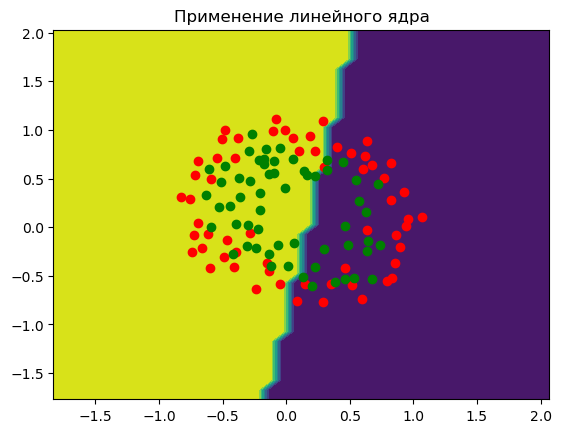

In [41]:
# Рисунок для датасета chips.csv при применении лучших гиперпараметров для линейного ядра
# Лучший показатель точности составляет 59.322033898305086 при данных гиперпараметрах: С = 0.5
printPlotsLinear(dates, xCord, yCord, 0.5)

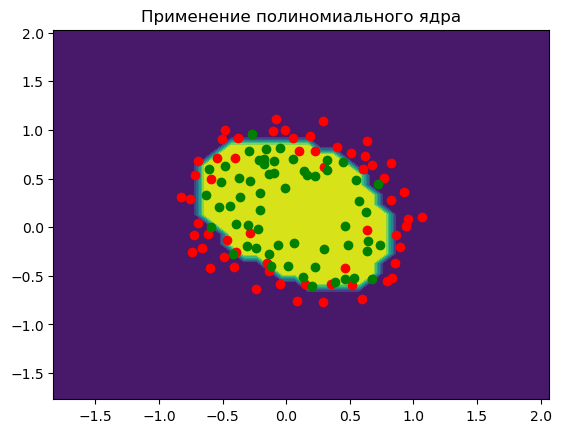

In [43]:
# Рисунок для датасета chips.csv при применении лучших гиперпараметров для полиномиального ядра
# Лучший показатель точности составляет 87.38738738738738 при данных гиперпараметрах: С = 0.01 и степенью полинома = 2
printPlotsPolynomial(dates, xCord, yCord, 0.01, 2)

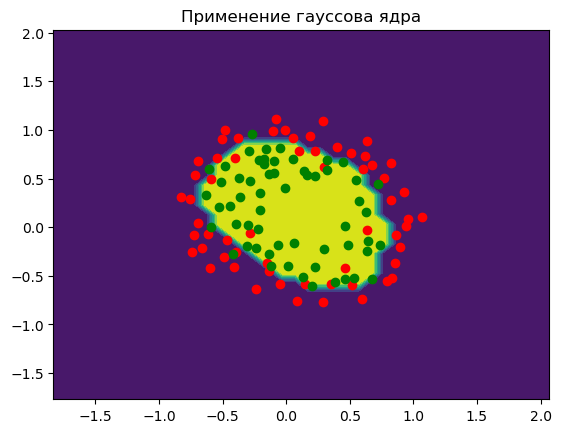

In [36]:
# Рисунок для датасета chips.csv при применении лучших гиперпараметров для гауссова ядра
# Лучший показатель точности составляет 88.64406779661016 при данных гиперпараметрах: С = 0.05 и beta = 4
printPlotsGaussian(dates, xCord, yCord, 0.05, 4)

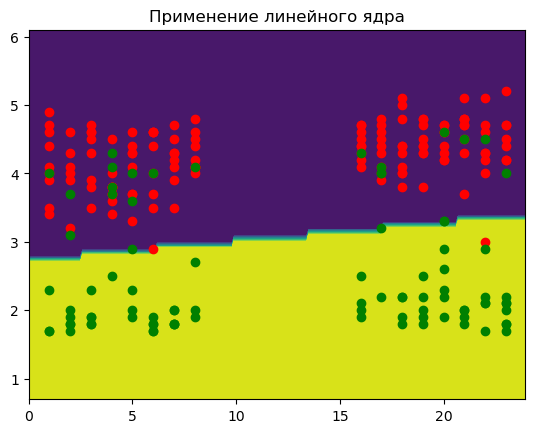

In [37]:
# Рисунок для датасета geyser.csv при применении лучших гиперпараметров для линейного ядра
# Лучший показатель точности составляет 89.18918918918919 при данных гиперпараметрах: С = 50.0
printPlotsLinear(dates, xCord, yCord, 50.0)

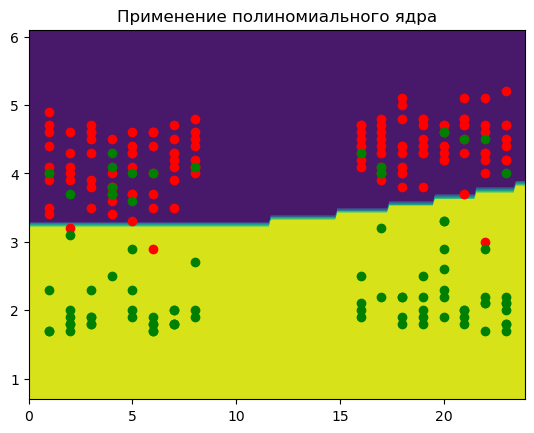

In [38]:
# Рисунок для датасета geyser.csv при применении лучших гиперпараметров для полиномиального ядра
# Лучший показатель точности составляет 90.54054054054054 при данных гиперпараметрах: С = 0.1 и степенью полинома = 2
printPlotsPolynomial(dates, xCord, yCord, 2, 0.1)

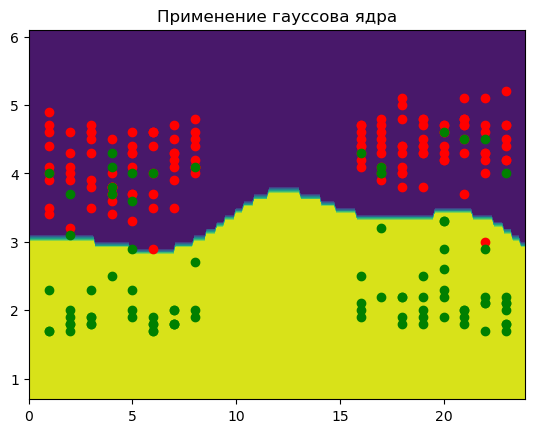

In [39]:
# Рисунок для датасета geyser.csv при применении лучших гиперпараметров для гауссова ядра
# Лучший показатель точности составляет 90.09009009009009 при данных гиперпараметрах: С = 0.5 и beta = 5
printPlotsGaussian(dates, xCord, yCord, 5, 0.5)